# Исследование оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов.   
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь.
	Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет.
	Подключение может быть двух типов: через телефонную линию
	(DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия»)
	или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года.
Доступны различные способы расчёта и возможность получения электронного чека.


# Описание данных

Данные состоят из файлов, полученных из разных источников:  

contract.csv — информация о договоре;  
personal.csv — персональные данные клиента;  
internet.csv — информация об интернет-услугах;  
phone.csv — информация об услугах телефонии.  

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

import warnings
warnings.filterwarnings("ignore")

## Получение и обработка данных

In [2]:
# Импортирование данных
data_path = '/datasets/final_provider/'

df = {
    'personal': pd.read_csv(data_path + 'personal.csv', index_col='customerID'),
    'contract': pd.read_csv(data_path + 'contract.csv', index_col='customerID'),
    'internet': pd.read_csv(data_path + 'internet.csv', index_col='customerID'),
    'phone': pd.read_csv(data_path + 'phone.csv', index_col='customerID')
}

In [3]:
# Вывод общей информации по всем полученным данным

def info(df):
    tbl_info = []
    for name, tbl in df.items():
        indx=[]
        col_info=[]
        format_str = "{count} non-null {dtype}"
        counts = tbl.count()
        dtypes = tbl.dtypes
        for i, col in enumerate(tbl.columns):
            indx.append(col)
            col_info.append(format_str.format(count=counts.iloc[i], dtype=dtypes.iloc[i]))
        tbl_name = [name for i in range(len(col_info))]
        tbl_info.append(pd.DataFrame(data={'table_name': tbl_name, 'col_name': indx,'info': col_info}))

    df_info = pd.concat(tbl_info)
    return df_info


info(df).pivot_table(index=['table_name', 'col_name'], values='info', aggfunc='first')


info
table_name col_name                               
contract   BeginDate          7043 non-null object
           EndDate            7043 non-null object
           MonthlyCharges    7043 non-null float64
           PaperlessBilling   7043 non-null object
           PaymentMethod      7043 non-null object
           TotalCharges       7043 non-null object
           Type               7043 non-null object
internet   DeviceProtection   5517 non-null object
           InternetService    5517 non-null object
           OnlineBackup       5517 non-null object
           OnlineSecurity     5517 non-null object
           StreamingMovies    5517 non-null object
           StreamingTV        5517 non-null object
           TechSupport        5517 non-null object
personal   Dependents         7043 non-null object
           Partner            7043 non-null object
           SeniorCitizen       7043 non-null int64
           gender             7043 non-null object
phone      MultipleLines      6361 non-null object

Итак, всего клиентов и их контрактов - 7043 шт. Из них имеют телефонные услуги - 6361 шт. и интернет-услуги - 5517 шт.  

Для удобства дальнейшего анализа объединим все данные в одну таблицу.

In [4]:
# Объединение данных в одну таблицу

df_all = df['contract'].join(df['personal']).join(df['phone']).join(df['internet']).sort_index()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: float64(1), int64(1), object(17)
memory usage: 1.1+ MB


In [5]:
df_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,Yes,No,DSL,No,Yes,No,Yes,Yes,No
0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,No,No,Yes,DSL,No,No,No,No,No,Yes
0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No,No,Fiber optic,No,No,Yes,No,No,No
0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes
0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Female,1,Yes,No,No,Fiber optic,No,No,No,Yes,Yes,No


**Примечание. Для решения нашей задачи прогнозирования оттока клиентов нам нужен целевой признак, отображающий некий статус - является ли персонаж клиентом или уже нет. Назовем его `client` со значениями 1-клиент и 0-не клиент. Сформируем его на основании признака EndData - если у него значение No, то контракт еще не закрыт и персонаж до сих пор является клиентом. В противном случае - договор закрыт и персонаж уже не является клиентом.**

In [6]:
df_all['client'] = df_all['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

In [7]:
# проверка пустых значений

df_all.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
client                 0
dtype: int64

Очевидно, если в поле есть пропуск, то это означает, что соответствующая услуга клиенту не предоставлялась.  
Поэтому все пропуски можно заполнить значением **No**.

In [8]:
df_all.fillna('No', inplace=True)

In [9]:
# Статистика по не числовым полям 

df_all.describe(include='object')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,77,5,3,2,4,6531,2,2,2,2,3,2,2,2,2,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,20.2,Male,No,No,No,Fiber optic,No,No,No,No,No,No
freq,366,5174,3875,4171,2365,11,3555,3641,4933,4072,3096,5024,4614,4621,4999,4336,4311


Большинство признаков имеют только два значения: **No** и **Yes**, которые для удобства дальнешего анализа можно смело поменять на 0 и 1 соответственно.  
Также всего два значения имеет признак **gender** - **Male** и **Female** - которые тоже можно поменять на 1 и 0 соответственно.  
Формат признаков **BeginDate** и **EndDate** - преобразуем в формат дат. А признаку **EndDate** со значением **No** присвоим значение текущей даты.

In [10]:
binary_fields = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'MultipleLines', 
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'client']

df_all = df_all.replace({'Yes': 1, 'No': 0})
df_all['gender'] = df_all['gender'].replace({'Male': 1, 'Female': 0})

In [11]:
# нулевые значения признака EndDate заменим на текущую дату

now = datetime.datetime.now().strftime("%Y-%m-%d")

df_all['EndDate'] = df_all['EndDate'].apply(lambda x: now if x == 0 else x)

In [12]:
# добавление признака period - срок действия контракта

df_all['BeginDate'] = pd.to_datetime(df_all['BeginDate'])
df_all['EndDate'] = pd.to_datetime(df_all['EndDate'])
df_all['period'] = (df_all['EndDate'] - df_all['BeginDate']).dt.days
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null int64
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
MultipleLines       7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
client              7043 non-null int64
period              7043 non-null int64
dtypes: datetime64[

In [13]:
df_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,client,period
customerID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-05-25,One year,1,Mailed check,65.6,593.3,0,0,1,...,0,DSL,0,1,0,1,1,0,1,390
0003-MKNFE,2019-05-01,2020-05-25,Month-to-month,0,Mailed check,59.9,542.4,1,0,0,...,1,DSL,0,0,0,0,0,1,1,390
0004-TLHLJ,2019-09-01,2020-01-01,Month-to-month,1,Electronic check,73.9,280.85,1,0,0,...,0,Fiber optic,0,0,1,0,0,0,0,122
0011-IGKFF,2018-12-01,2020-01-01,Month-to-month,1,Electronic check,98.0,1237.85,1,1,1,...,0,Fiber optic,0,1,1,0,1,1,0,396
0013-EXCHZ,2019-09-01,2019-12-01,Month-to-month,1,Mailed check,83.9,267.4,0,1,1,...,0,Fiber optic,0,0,0,1,1,0,0,91


***

## Анализ числовых признаков

In [14]:
# Статистические показатели числовых полей. Добавим количество уникальных значений

describes = df_all.describe()
uniques = [df_all[col].unique().__len__() for col in describes.columns]
uniques = pd.Series(uniques, index=describes.columns, name='uniques').to_frame().T

In [15]:
describes = pd.concat([describes, uniques])
describes

,PaperlessBilling,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,client,period
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,0.504756,0.162147,0.483033,0.299588,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.734630,1069.744001
std,0.491457,30.090047,0.500013,0.368612,0.499748,0.458110,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.441561,766.788846
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,0.000000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000
50%,1.000000,70.350000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,967.000000
75%,1.000000,89.850000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1790.000000
max,1.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2305.000000
uniques,2.000000,1585.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,204.000000


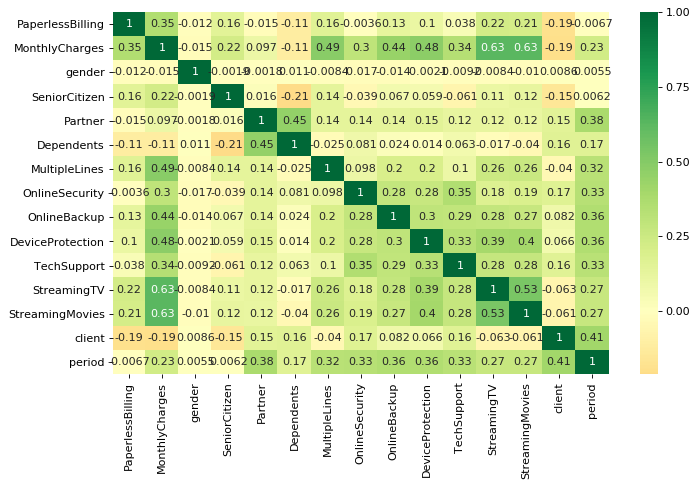

In [16]:
# матрица корреляций

plt.figure(figsize=(10,6), dpi= 80)
sns.heatmap(df_all.corr(), 
            xticklabels=df_all.corr().columns, 
            yticklabels=df_all.corr().columns, 
            cmap='RdYlGn', center=0, annot=True)
plt.show()

***

### Сравнение распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл.   

Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:

- долю пользователей телефонной связи;
- долю интернет-пользователей.


In [17]:
# Количество уникальных значений 

print('Уникальные значения:')
df_all['MonthlyCharges'].value_counts().to_frame().T

Уникальные значения:


,20.05,19.85,19.95,19.90,19.65,19.70,20.00,19.55,20.15,19.75,...,113.40,61.80,35.25,37.70,66.75,116.30,107.15,68.55,43.65,35.35
MonthlyCharges,61,45,44,44,43,43,43,40,40,39,...,1,1,1,1,1,1,1,1,1,1


In [18]:
# Формирование таблицы с величинами ежемесячных платежей клиентов

current_clients = df_all[['MonthlyCharges', 'client']]
current_clients.head()

,MonthlyCharges,client
customerID,,
0002-ORFBO,65.6,1
0003-MKNFE,59.9,1
0004-TLHLJ,73.9,0
0011-IGKFF,98.0,0
0013-EXCHZ,83.9,0


In [19]:
df_monthly_charges = current_clients.reset_index()\
    .pivot_table(index='customerID', columns='client', 
                 values='MonthlyCharges', aggfunc='sum', 
                 margins=True).drop('All')
df_monthly_charges.columns = ['no_client', 'is_client', 'sum_charges']
df_monthly_charges.head()

,no_client,is_client,sum_charges
customerID,,,
0002-ORFBO,NaN,65.6,65.6
0003-MKNFE,NaN,59.9,59.9
0004-TLHLJ,73.9,NaN,73.9
0011-IGKFF,98.0,NaN,98.0
0013-EXCHZ,83.9,NaN,83.9


In [20]:
df_monthly_charges.describe()

,no_client,is_client,sum_charges
count,1869.000000,5174.000000,7043.000000
mean,74.441332,61.265124,64.761692
std,24.666053,31.092648,30.090047
min,18.850000,18.250000,18.250000
25%,56.150000,25.100000,35.500000
50%,79.650000,64.425000,70.350000
75%,94.200000,88.400000,89.850000
max,118.350000,118.750000,118.750000


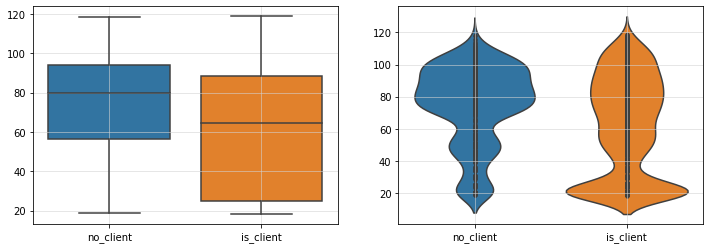

In [21]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
sns.boxplot(data=df_monthly_charges[['no_client', 'is_client']], ax=axes[0])
axes[0].grid(color='lightgray', alpha=0.7)
sns.violinplot(data=df_monthly_charges[['no_client', 'is_client']], inner="points", ax=axes[1])
axes[1].grid(color='lightgray', alpha=0.7)
plt.show()

Как видно из представленных диаграмм и статистических данных средний уровнь платежей тех клиентов, которые ушли, значительно выше, чем у действующих клиентов. Т.е. это, в основном люди, которые не довольны высокой платой за услуги.  
Но не мало и тех, у которых ежемесячная плата на минимальных значениях. Значит эти люди могут быть не довольны качеством предлагаемых услуг.

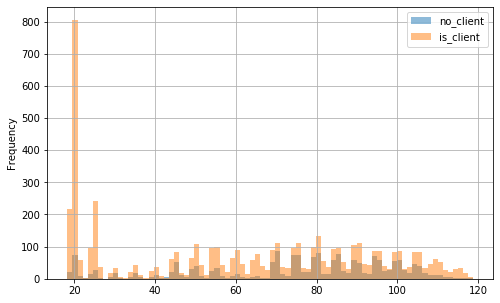

In [22]:
# Гистаграммы 

ax = df_monthly_charges[['no_client', 'is_client']].plot\
    .hist(bins=80, alpha=0.5, grid=True, figsize=(8, 5));

In [23]:
# добавим в таблицу признаки наличия телефонных услуг и интернет-услуг

df_monthly_charges = (
    df_monthly_charges
    .join(pd.Series(1, df['internet'].index, name='inet'))
    .join(pd.Series(1, df['phone'].index, name='phone'))
)
df_monthly_charges.head()

,no_client,is_client,sum_charges,inet,phone
customerID,,,,,
0002-ORFBO,NaN,65.6,65.6,1.0,1.0
0003-MKNFE,NaN,59.9,59.9,1.0,1.0
0004-TLHLJ,73.9,NaN,73.9,1.0,1.0
0011-IGKFF,98.0,NaN,98.0,1.0,1.0
0013-EXCHZ,83.9,NaN,83.9,1.0,1.0


In [24]:
df_monthly_charges['inet'] = df_monthly_charges['inet'].fillna(0).astype(int)
df_monthly_charges['phone'] = df_monthly_charges['phone'].fillna(0).astype(int)

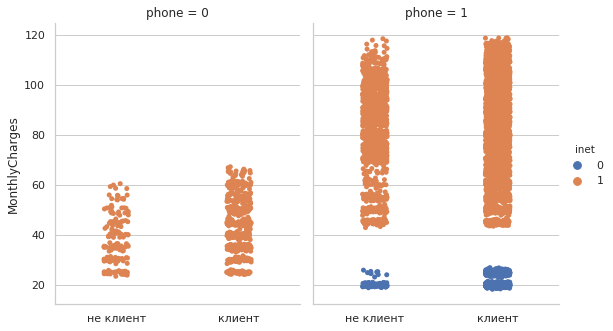

In [25]:
df_monthly_charges = df_monthly_charges.join(df_all['client'])

sns.set(style="whitegrid")
g = sns.catplot(x="client", y="sum_charges", col="phone", hue='inet', 
                data=df_monthly_charges, 
                kind="strip", height=5, aspect=0.8)
g.set_axis_labels("", "MonthlyCharges").set_xticklabels(["не клиент", "клиент"]);


Разберем эту диаграмму.  

В левой части обозначены клиенты и бывшие клиенты, которые не имеют/не имели телефонных услуг - только интернет услуги.  
Эта категория клиентов оказалась с небольшими ежемесячными платами за услуги.  

В правой части - это клиенты с имеющие/имевшие телефонные услуги. Их них очень не значительная часть не имеет интернет услуг. Особенно среди тех, кто перестал быть клиентом.  

Напрашивается предварительный вывод - уходящие клиенты, в основном, не довольны либо стоимостью интернет услуг, либо их качеством.  

Интересно посмотреть все в цифрах - количество, доли...

In [26]:
df_monthly_charges.pivot_table(index=['phone', 'client'], columns='inet', values='sum_charges', 
                               aggfunc=['count', 'sum'], fill_value='', margins=True)

count                    sum                      
inet             0       1   All        0          1        All
phone client                                                   
0     0              170.0   170             6380.75    6380.75
      1              512.0   512            22282.75   22282.75
1     0        113  1586.0  1699   2301.6  130448.50  132750.10
      1       1413  3249.0  4662  29865.3  264837.75  294703.00
All           1526  5517.0  7043  32166.8  423949.75  456116.60

Понятно, что если нет телефонных услуг и интернет-услуг, то эти поля будут пустые.  

Далее, при отсутствии телефонных услуг, но с интернет-услугами оказалось 682 клиента. Из них 170 - бывших, или 25%. Сумма платежей таких клиентов составила 28 667 р., из них бывших клиентов - 6381 р. или 22%.  

Теперь разберем тех, кто имел телефонные услуги, но ушел.  
Всего таких 1699 чел. Их них только 113 не имели интернет-услуг (6,7% от ушедших). Т.е. подавляющее большинство уходящих - это интернет-пользователи. 
***

## Анализ признаков с датами

In [27]:
df_all.describe(include='datetime')

,BeginDate,EndDate
count,7043,7043
unique,77,5
top,2014-02-01 00:00:00,2020-05-25 00:00:00
freq,366,5174
first,2013-10-01 00:00:00,2019-10-01 00:00:00
last,2020-02-01 00:00:00,2020-05-25 00:00:00


В целом, на мой взляд, **признак BeginDate является важным признаком**.   
Ведь в какой-то год может быть больше привлеченных клиентов, а в какой-то - меньше. Это может произойти,например, из-за кризиса в стране или не удачной тарифной или рекламной политики в этот период.   

Но конкретно в этой задаче для прогнозирования оттока клиентов год, когда клиент заключил договор, не играет роли.
Поэтому можем эту дату удалить.

Признак EndDate тоже не является важным. Его роль - создание признака длительности контракта  period. Ну и в нашем случае еще при создании целевого признака client.
Поэтому его тоже смело можно удалить.  

In [28]:
df_all = df_all.drop(['BeginDate', 'EndDate'], axis=1)

***

## Анализ не числовых признаков

In [30]:
df_all.describe(include='object')

,Type,PaymentMethod,TotalCharges,InternetService
count,7043,7043,7043,7043
unique,3,4,6531,3
top,Month-to-month,Electronic check,20.2,Fiber optic
freq,3875,2365,11,3096


In [31]:
# анализ поля TotalCharges
print('isna:', (df_all['TotalCharges'].isna()).sum())
print('empty:', (df_all['TotalCharges'] == '').sum())
print('space:', (df_all['TotalCharges'] == ' ').sum())

isna: 0
empty: 0
space: 11


In [55]:
empties = df['contract'][df['contract']['TotalCharges'] == ' ']
empties.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


In [33]:
(df['contract'] == '2020-02-01').sum()

BeginDate           11
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
dtype: int64

В признаке TotalCharges закрались 11 пустых значений.  
Все эти случаи относятся к договорам, открытым 01.02.2020 г. - т.е. на дату актуализации данных. Это новые клиенты, которые еще не успели провести какие-либо оплаты по договору.  

Для дальнейшего анализа эти случаи не актуальны и их можно удалить.


In [34]:
df_all = df_all.drop(index=empties.index)

In [35]:
df_all['TotalCharges'] = df_all['TotalCharges'].astype(float)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null int64
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
MultipleLines       7032 non-null int64
InternetService     7032 non-null object
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
client              7032 non-null int64
period              7032 non-null int64
dtypes: float64(2), int64(14), object(3)
memory usage: 1.1+ MB


In [36]:
object_fields = df_all.dtypes[df_all.dtypes == 'object'].index.tolist()
object_fields

['Type', 'PaymentMethod', 'InternetService']

Таким образом, не числовых полей осталось 3 штуки.  
Далее к ним будут применены общепринятые кодировки.
***

***
### Трансформация не числовых признаков. Разбивка данных на тренировочные и валидационные

In [37]:
df_ohe = pd.get_dummies(df_all, drop_first=True)
df_ohe.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,...,StreamingMovies,client,period,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,1,65.6,593.30,0,0,1,1,0,0,1,...,0,1,390,1,0,0,0,1,1,0
0003-MKNFE,0,59.9,542.40,1,0,0,0,1,0,0,...,1,1,390,0,0,0,0,1,1,0
0004-TLHLJ,1,73.9,280.85,1,0,0,0,0,0,0,...,0,0,122,0,0,0,1,0,0,1
0011-IGKFF,1,98.0,1237.85,1,1,1,0,0,0,1,...,1,0,396,0,0,0,1,0,0,1
0013-EXCHZ,1,83.9,267.40,0,1,1,0,0,0,0,...,0,0,91,0,0,0,0,1,0,1


In [38]:
target = df_ohe['client']
features = df_ohe.drop('client', axis=1)

In [39]:
RND_STATE = 2112


In [40]:
# для борьбы с дисбаласом создана функция downsample, уменьшающая более многочисленный класс

x_train, x_valid, y_train, y_valid = train_test_split(features, target, 
                                                      test_size=0.25, 
                                                      random_state=RND_STATE)

def downsample(features, target, fraction):
    from sklearn.utils import shuffle

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_ones.sample(frac=fraction, random_state=RND_STATE)] + [features_zeros])
    target_downsampled = pd.concat(
        [target_ones.sample(frac=fraction, random_state=RND_STATE)] + [target_zeros])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RND_STATE)
    
    return features_downsampled, target_downsampled

x_train, y_train = downsample(x_train, y_train, 0.6)
print(y_train.value_counts())


1    2320
0    1408
Name: client, dtype: int64


***

# Модели

In [41]:
cv = TimeSeriesSplit(4)
best_models = dict(best_model=[], roc_auc=[], accuracy=[], recall=[], precision=[])


def run_model(pipe, params):
    model = GridSearchCV(pipe, params, scoring='roc_auc', 
                         verbose=1, cv=cv, n_jobs=-1)
    model.fit(x_train, y_train)

    predicted_valid = model.predict(x_valid)
    rocauc_valid = roc_auc_score(y_valid, predicted_valid)
    accuracy_valid = accuracy_score(y_valid, predicted_valid)
    recall_valid = recall_score(y_valid, predicted_valid)
    precision_valid = precision_score(y_valid, predicted_valid)
    print('roc_auc: {: >10.6f}'.format(rocauc_valid))
    print('accuracy: {: >9.6f}'.format(accuracy_valid))
    print('recall: {: >11.6f}'.format(recall_valid))
    print('precision: {: >8.6f}'.format(precision_valid))
    
    best_models['best_model'].append(model.best_params_['estimator'])
    best_models['roc_auc'].append(rocauc_valid)
    best_models['accuracy'].append(accuracy_valid)
    best_models['recall'].append(recall_valid)
    best_models['precision'].append(precision_valid)

### LogisticRegression

In [42]:
pipe = Pipeline([('estimator', LogisticRegression())])
params_grid = [
    {
        'estimator': [LogisticRegression(random_state=RND_STATE, solver='liblinear')],
        'estimator__max_iter': [100, 500],
        'estimator__C': [0.05, 0.1, 0.5, 1],
        'estimator__class_weight': ['balanced', None],
    },
]

run_model(pipe, params_grid)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc:   0.816654
accuracy:  0.836746
recall:    0.858905
precision: 0.914614


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   12.0s finished


### RandomForestClassifier

In [43]:
pipe = Pipeline([('estimator', RandomForestClassifier())])
params_grid = [
    {
        'estimator': [RandomForestClassifier(random_state=RND_STATE)],
        'estimator__max_depth': range(3, 20, 4),
        'estimator__n_estimators': [50, 100, 300],
        'estimator__min_samples_leaf': range(2, 13, 2),
        'estimator__class_weight': ['balanced', None],
    },
]

run_model(pipe, params_grid)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.2min finished


roc_auc:   0.814172
accuracy:  0.836177
recall:    0.860447
precision: 0.912510


### BaggingClassifier

In [44]:
pipe = Pipeline([('estimator', BaggingClassifier())])
params_grid = [
    {
        'estimator': [BaggingClassifier(random_state=RND_STATE)],
        'estimator__n_estimators': [10, 50, 100],
        'estimator__max_samples': [0.5, 1.],
        'estimator__max_features': [0.8, 0.9, 1.],
    },
]

run_model(pipe, params_grid)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   22.3s finished


roc_auc:   0.895884
accuracy:  0.928896
recall:    0.965305
precision: 0.939940


### AdaBoostClassifier

In [45]:
pipe = Pipeline([('estimator', AdaBoostClassifier())])
params_grid = [
    {
        'estimator': [AdaBoostClassifier(random_state=RND_STATE)],
        'estimator__learning_rate': [1, 0.5, 0.1],
        'estimator__n_estimators': [50, 100, 200],
    },
]

run_model(pipe, params_grid)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.1s finished


roc_auc:   0.898393
accuracy:  0.924346
recall:    0.952968
precision: 0.944954


### KNeighborsClassifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('estimator', AdaBoostClassifier())])
params_grid = [
    {
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': [5, 9, 13],
        'estimator__weights': ['uniform', 'distance'],
        'estimator__leaf_size': [20, 30, 40],
    },
]

run_model(pipe, params_grid)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc:   0.863229
accuracy:  0.904437
recall:    0.949884
precision: 0.922846


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.1s finished


In [47]:
best_models = pd.DataFrame(best_models)

In [48]:
best_models['name'] = ''
for i in best_models.index:
    best_models.loc[i, 'name'] = best_models.loc[i, 'best_model'].__str__().split('(')[0]
best_models

,best_model,roc_auc,accuracy,recall,precision,name
0,"LogisticRegression(C=0.1, class_weight=None, d...",0.816654,0.836746,0.858905,0.914614,LogisticRegression
1,"(DecisionTreeClassifier(class_weight=None, cri...",0.814172,0.836177,0.860447,0.912510,RandomForestClassifier
2,"(DecisionTreeClassifier(class_weight=None, cri...",0.895884,0.928896,0.965305,0.939940,BaggingClassifier
3,"(DecisionTreeClassifier(class_weight=None, cri...",0.898393,0.924346,0.952968,0.944954,AdaBoostClassifier
4,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.863229,0.904437,0.949884,0.922846,KNeighborsClassifier


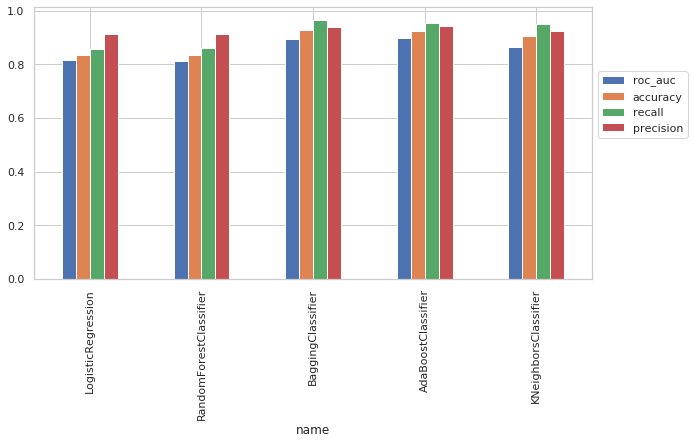

In [49]:
ax = best_models[['roc_auc','accuracy','recall', 'precision', 'name']].plot(kind='bar', x='name', figsize=(10,5));
ax.legend(loc='lower left', bbox_to_anchor= (1.0, .5));

### Лучшая модель

Основная метрика: AUC_ROC.  
Дополнительная метрика: Accuracy.  
Критерии оценки:  
AUC_ROC < 0.75 — 0 sp  
0.75 ≤ AUC_ROC < 0.81 — 4 sp  
0.81 ≤ AUC_ROC < 0.85 — 4.5 sp  
0.85 ≤ AUC_ROC < 0.87 — 5 sp  
0.87 ≤ AUC_ROC < 0.88 — 5.5 sp  
AUC_ROC ≥ 0.88 — 6 sp

Как видно порог в 0,85 преодолели три вида моделей. Два из них превысило крайний порог в 0,88!  
Но лучшей по показателям оказалась модель AdaBoostClassifier.

In [52]:
print('Лушая модель:', best_models.loc[3, 'name'])
best_model = best_models.loc[2, 'best_model']
print('Параметры модели:')
best_model.get_params()

Лушая модель: AdaBoostClassifier
Параметры модели:


{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2112,
 'verbose': 0,
 'warm_start': False}

In [53]:
# для примера проведем расчет по всему датасету

predicted_ = best_model.predict(features)
rocauc_ = roc_auc_score(target, predicted_)
accuracy_ = accuracy_score(target, predicted_)
recall_ = recall_score(target, predicted_)
precision_ = precision_score(target, predicted_)
print('roc_auc:', rocauc_)
print('accuracy:', accuracy_)
print('recall:', recall_)
print('precision:', precision_)


roc_auc: 0.9684296741632104
accuracy: 0.9736916951080774
recall: 0.979662986635677
precision: 0.9844297391981316


***